# Analytics - visualization

This notebook provides a set of graphs for visualizing the main theoretical results and functions for the linear classification of structured data and a quick comparison with the same quantities for unstructured data. For a rigorous explanation of the reported quantities, see papers linked in the references.

In [1]:
import itertools
from decimal import Decimal
import multiprocessing as mp
from shapely.geometry import LineString
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt

import worker_module as wm

%matplotlib inline
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

In [2]:
# Useful functions for analysis

def C_cover_matrix(n,p):

    '''Return number of admissible dichotomies C(n,p) for unstructured data (Cover) using recursion relation'''

    assert isinstance(n, int) and n > 0
    assert p > 0

    # Set the matrix
    grid = np.empty((n+1,p+1), dtype=Decimal)
    grid.fill(Decimal('0'))

    # Fill row n = 0
    for i in range(p+1):
        grid[0][i] = Decimal('0')

    # Fill column p = 0 (useless for this computation)
    for i in range(n+1):
        grid[i][0] = Decimal('0')

    # Fill p = 1 for all n
    for i in range(1,n+1):
        grid[i][1] = Decimal('2')

    # Fill n = 1 using recursione (with cut)
    for i in range(2,p+1):
        grid[1][i] = grid[1][i-1]

    # Fill the matrix column by column (using recursion)
    for P in range(2,p+1):
        for N in range(2,n+1):
            grid[N][P] = grid[N][P-1] + grid[N-1][P-1]


    return grid[n][p]


def psi2(rho: float) -> float:
    
    '''Symmetrized probability psi_2(rho)'''
    
    return (2./np.pi) * np.arctan(np.sqrt((1. + rho) / (1. - rho)))


def krondelta(i: int, j: int) -> int:
    
    '''Kronecker delta element i,j'''
    
    assert isinstance(i, int) and isinstance(j, int)
    
    return 1 if i == j else 0


def C_recursive(n: int, p: int, rho: float) -> int:
    
    '''Return number of admissible dichotomies C(n,p) for fixed rho using recursion relation'''
    
    assert isinstance(n, int) and n >= 0
    assert isinstance(p, int) and p > 0
    
    if n == 0:
        return 0
    elif p == 1:
        return 2*(1 - (1 - psi2(rho))*krondelta(n,1))
    
    if n == 1:
        return psi2(rho)*C(1,p-1,rho)
    
    return psi2(rho)*C(n, p-1, rho) + C(n-1, p-1, rho) + (1. - psi2(rho))*C(n-2, p-1, rho)


def C_matrix(n: int, p: int, rho: float) -> int:
    
    '''Return number of admissible dichotomies C(n,p) for fixed rho using a lookup table'''
    
    assert isinstance(n, int) and n > 0
    assert p > 0
    
    # Set table
    grid = np.zeros((n + 1, p + 1))
    grid.fill(np.nan)
    
    # Fill row n = 0
    for i in range(p + 1):
        grid[0][i] = 0
        
    # Fill column p = 0 (even though it's useless for this computation)
    for i in range(n + 1):
        grid[i][0] = 0
    
    # Fill p = 1 for all n
    for i in range(1, n + 1):
        grid[i][1] = 2*(1. - (1. - psi2(rho))*krondelta(i,1))
    
    # Fill n = 1 using recursione (with cut)
    for i in range(2, p + 1):
        grid[1][i] = psi2(rho)*grid[1][i-1]
        
    # Fill the matrix column by column (using recursion)
    for P in range(2, p + 1):
        for N in range(2, n + 1):
            # Consistency check
            if grid[N][P-1] == np.nan or grid[N-1][P-1] == np.nan or grid[N-2][P-1] == np.nan:
                print("WARNING: ", grid[N][P-1], grid[N-1][P-1], grid[N-2][P-1])
                
            grid[N][P] = psi2(rho)*grid[N][P-1] + grid[N-1][P-1] + (1 - psi2(rho))*grid[N-2][P-1]
            
    return grid[n][p]


def c_k2(n: int, p: int, rho: float) -> float:
    
    '''Return the fraction of admissible dichotomies c(n,p) for fixed rho and k=2'''
    
    return float(Decimal(C_matrix(n,p,rho)) / Decimal(2**p))
    
    
def alpha_c(rho: float) -> float:
    
    return 2./(3 - 2*psi2(rho))

In [3]:
def compute_entropy(N: int, rho: float, alpha_min: float, alpha_max: float) -> tuple:
    
    '''
        Compute the VC entropy for given model.
        This function returns a tuple with a list of alphas and the corresponding entropies. 
    '''
    
    P_min = int(N*alpha_min)
    P_max = int(N*alpha_max)
    
    Ps = np.array(range(P_min, P_max + 1))
    entropy = np.log(np.array([C_matrix(N,P,rho) for P in Ps]))
    
    return Ps/N, entropy


def compute_intersection(curve0, curve1):
    
    '''Return the intersection point between two curves'''
    
    
    line0 = LineString( np.column_stack((curve0[0],curve0[1])) )
    line1 = LineString( np.column_stack((curve1[0],curve1[1])) )

    intersection = line0.intersection(line1)
    
    
    x_inter, y_inter = intersection.xy
    
    return x_inter[0], y_inter[0]

## Symmetrized probability for doublets - $\psi_2$
The analytic formula for this function is:
$$
    \psi_2 (\rho) = \frac{2}{\pi} \sqrt{\frac{1 + \rho}{1 - \rho}}
$$

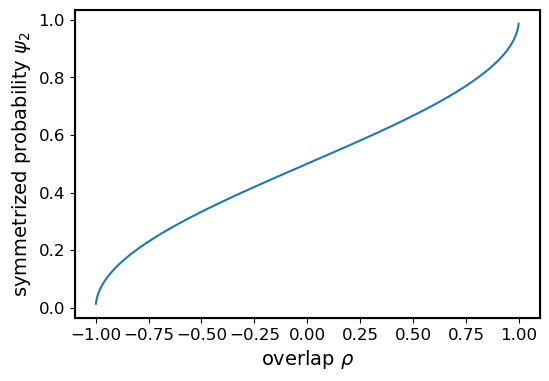

In [4]:
x = np.linspace(-0.999, 0.999, 1000)
y_psi2 = psi2(x)

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(x, y_psi2)
ax.set_xlabel(r'overlap $\rho$')
ax.set_ylabel(r'symmetrized probability $\mathit{\psi_2}$')
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1.5')  

## Storage capacity - $\alpha_c$

The combinatorial theory allows to generalize the notion of storage capacity to the structured data case:
$$
\alpha_c (\rho) = \frac{2}{3 - \psi_2 (\rho)}
$$

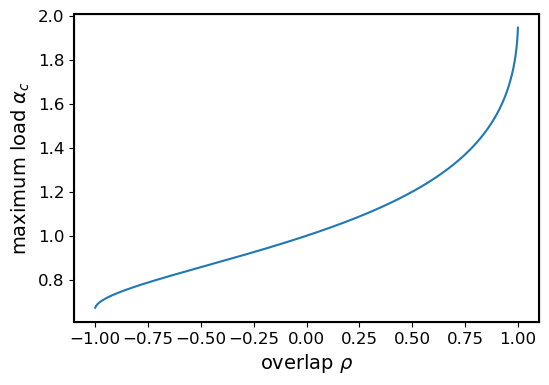

In [5]:
x = np.linspace(-0.999, 0.999, 1000)
y_ac = alpha_c(x)

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(x, y_ac)
ax.set_xlabel(r'overlap $\rho$')
ax.set_ylabel(r'maximum load $\mathit{\alpha_c}$')
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1.5')

## Number of admissible dichotomies - $C_{n,p}$

The number of admissible dichotomies is the key quantity for this investigation. It consists in the number of different linear classification realized by a linear classifier withoutvioleting the constraints of the problem.

Cover's theorem provides the quantity $C_{n,p}$ in the case of unstructured data:
$$
C_{n,p} = 2 \sum_{k=0}^{n-1} \binom{p-1}{k}
$$
It can be rewritten with a simple recurrence relation:
$$
\begin{align}
C_{n,p+1} &= C_{n,p} + C_{n-1,p} \\
C_{n\ge 1,1} &= 2 \\
C_{0,p} &= 0
\end{align}
$$

Similarly to Cover's theorem, it's possible to formulate a recurrence relation for the number of admissible dichotomies for structured data.\
Here, we report only the result for doublets:

$$
\begin{align}
C_{n,p+1} &= \psi_2 (\rho) C_{n,p} + C_{n-1,p} + [1 - \psi_2 (\rho)] C_{n-2,p} \\
C_{n\ge 1, 1} &= 2\{1 - [1 - \psi_2 (\rho)] \delta_{n,1}\} \\
C_{0,p} &= 0
\end{align}
$$

In [6]:
N_1, N_2, N_3 = 3, 4, 5

# Unstructured
l_1_c, l_2_c, l_3_c = [], [], []
a_1_c, a_2_c, a_3_c = [], [], []
factor = 5

l_1_c = [C_cover_matrix(N_1,P) for P in range(1,int(factor*N_1))]
a_1_c = [P/N_1 for P in range(1,int(factor*N_1))]

l_2_c = [C_cover_matrix(N_2,P) for P in range(1,int(factor*N_2))]
a_2_c = [P/N_2  for P in range(1,int(factor*N_2))]

l_3_c = [C_cover_matrix(N_3,P) for P in range(1,int(factor*N_3))]
a_3_c = [P/N_3  for P in range(1,int(factor*N_3))]

# Structured
l_1, l_2, l_3 = [], [], []
a_1, a_2, a_3 = [], [], []
rho = 0.3
factor = 6

l_1 = [C_matrix(N_1,P,rho) for P in range(1,int(factor*N_1))]
a_1 = [P/N_1 for P in range(1,int(factor*N_1))]

l_2 = [C_matrix(N_2,P,rho) for P in range(1,int(factor*N_2))]
a_2 = [P/N_2  for P in range(1,int(factor*N_2))]

l_3 = [C_matrix(N_3,P,rho) for P in range(1,int(factor*N_3))]
a_3 = [P/N_3  for P in range(1,int(factor*N_3))]

C:\Users\giovanni\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  
C:\Users\giovanni\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  if __name__ == "__main__":


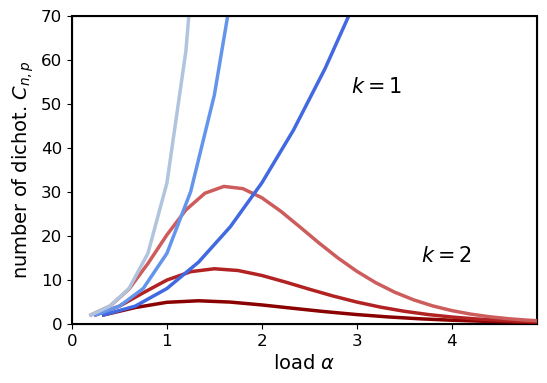

In [7]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(a_1, l_1, label='N=3', color='darkred', linewidth=2.5)
ax.plot(a_2, l_2, label='N=4', color='firebrick', linewidth=2.5)
ax.plot(a_3, l_3, label='N=5', color='indianred', linewidth=2.5)
ax.plot(a_1_c, l_1_c, label='N=3_c', color='royalblue', linewidth=2.5)
ax.plot(a_2_c, l_2_c, label='N=4_c', color='cornflowerblue', linewidth=2.5)
ax.plot(a_3_c, l_3_c, label='N=5_c', color='lightsteelblue', linewidth=2.5)
ax.annotate(r'$k=1$', (0.6, 0.75), textcoords='axes fraction', size=15)
ax.annotate(r'$k=2$', (0.75, 0.20), textcoords='axes fraction', size=15)
ax.set_xlabel(r'load $\alpha$')
ax.set_ylabel(r'number of dichot. $\mathit{C_{n,p}}$')
ax.set_xlim([0,4.9])
ax.set_ylim([0,70])
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1.5')  

## Fraction of dichotomies for unstructured data (k = 1)

The fraction of admissible dichotomies can be easily computed starting from the total number of admissible dichotomies (both for unstructured and structured data):

$$
c_{n,p} = C_{n,p} \,\, / \,\, 2^p
$$

In [8]:
if __name__ == '__main__':
    
    cores = 4
    N_1, N_2, N_3, N_4 = 25, 100, 500, 1000
    l_1, l_2, l_3, l_4 = [], [], [], []
    a_1, a_2, a_3, a_4 = [], [], [], []

    l_1 = [float(C_cover_matrix(N_1,P) / Decimal(2**P)) for P in range(N_1, 3*N_1)]
    a_1 = [P/N_1 for P in range(N_1, 3*N_1)]
    print(f"End for N = {N_1}")

    l_2 = [float(C_cover_matrix(N_2,P) / Decimal(2**P)) for P in range(N_2, 3*N_2)]
    a_2 = [P/N_2  for P in range(N_2,3*N_2)]
    print(f"End for N = {N_2}")

    pool = mp.Pool(processes=cores)
    with pool:
        l_3 = pool.starmap(wm.c_cover_wm, [(N_3, P) for P in range(N_3,3*N_3,10)])

    pool.join()

    a_3 = [P/N_3  for P in range(N_3,3*N_3,10)]
    print(f"End for N = {N_3}")

    pool = mp.Pool(processes=cores)
    with pool:
        l_4 = pool.starmap(wm.c_cover_wm, [(N_4, P) for P in range(N_4, 3*N_4, 20)])

    pool.join()

    a_4 = [P/N_4  for P in range(N_4, 3*N_4, 20)]
    print(f"End for N = {N_4}")

End for N = 25
End for N = 100
End for N = 500
End for N = 1000


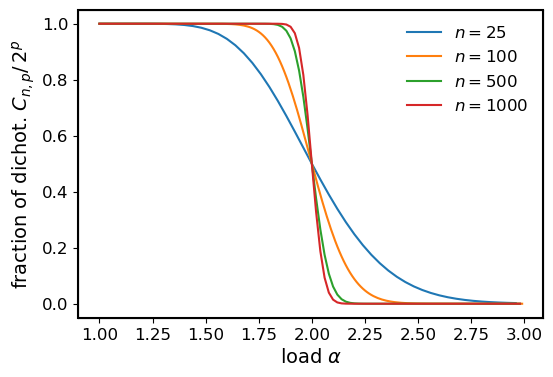

In [9]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(a_1, l_1, label=r'$n=25$')
ax.plot(a_2, l_2, label=r'$n=100$')
ax.plot(a_3, l_3, label=r'$n=500$')
ax.plot(a_4, l_4, label=r'$n=1000$')
ax.set_xlabel(r'load $\alpha$')
ax.set_ylabel(r'fraction of dichot. $\mathit{C_{n,p}/\,2^p}$')
ax.legend(framealpha=0.0)
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1.5')

## Fraction of dichotomies for structured data (k = 2)

In [10]:
if __name__ == '__main__':
    
    cores = 4
    N_1, N_2, N_3, N_4 = 50, 100, 500, 1000
    l_1, l_2, l_3, l_4 = [], [], [], []
    a_1, a_2, a_3, a_4 = [], [], [], []
    rho = -0.5

    l_1 = [c_k2(N_1,P,rho) for P in range(int(0.5*N_1),int(1.5*N_1))]
    a_1 = [P/N_1 for P in range(int(0.5*N_1),int(1.5*N_1))]
    print(f"End for N = {N_1}")

    l_2 = [c_k2(N_2,P,rho) for P in range(int(0.5*N_2),int(1.5*N_2))]
    a_2 = [P/N_2  for P in range(int(0.5*N_2),int(1.5*N_2))]
    print(f"End for N = {N_2}")

    pool = mp.Pool(processes=cores)
    with pool:
        l_3 = pool.starmap(wm.c_k2_wm, [(N_3, P, rho) for P in range(int(0.5*N_3),int(1.5*N_3),5)])

    pool.join()
    a_3 = [P/N_3  for P in range(int(0.5*N_3),int(1.5*N_3),5)]
    print(f"End for N = {N_3}")

    pool = mp.Pool(processes=cores)
    with pool:
        l_4 = pool.starmap(wm.c_k2_wm, [(N_4, P, rho) for P in range(int(0.5*N_4),int(1.5*N_4),10)])

    pool.join()
    a_4 = [P/N_4  for P in range(int(0.5*N_4),int(1.5*N_4),10)]
    print(f"End for N = {N_4}")

End for N = 50
End for N = 100
End for N = 500
End for N = 1000


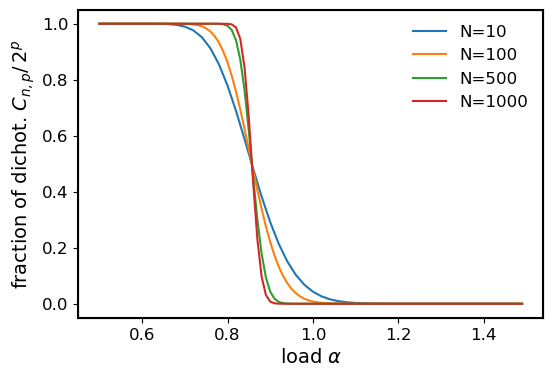

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(a_1, l_1, label='N=10')
ax.plot(a_2, l_2, label='N=100')
ax.plot(a_3, l_3, label='N=500')
ax.plot(a_4, l_4, label='N=1000')
ax.set_xlabel(r'load $\alpha$')
ax.set_ylabel(r'fraction of dichot. $\mathit{C_{n,p}/\,2^p}$')
ax.legend(framealpha=0.0)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('1.5')

## Fraction of dichotomies - comparison

In [12]:
# Unstructured
N_1, N_2, N_3 = 5, 10, 20
l_1, l_2, l_3 = [], [], []
a_1, a_2, a_3 = [], [], []
fct = 0.5

l_1 = [C_cover_matrix(N_1,P)/2**P for P in range(int(fct*N_1),25)]
a_1 = [P/N_1 for P in range(int(fct*N_1),25)]

l_2 = [C_cover_matrix(N_2,P)/2**P for P in range(int(fct*N_2),50)]
a_2 = [P/N_2  for P in range(int(fct*N_2),50)]

l_3 = [C_cover_matrix(N_3,P)/2**P for P in range(int(fct*N_3),100)]
a_3 = [P/N_3  for P in range(int(fct*N_3),100)]

# Structured
l_1_k2, l_2_k2, l_3_k2 = [], [], []
a_1_k2, a_2_k2, a_3_k2 = [], [], []

l_1_k2 = [c_k2(N_1,P,0.) for P in range(2,25)]
a_1_k2 = [P/N_1 for P in range(2,25)]

l_2_k2 = [c_k2(N_2,P,0.) for P in range(2,50)]
a_2_k2 = [P/N_2  for P in range(2,50)]

l_3_k2 = [c_k2(N_3,P,0.) for P in range(2,100)]
a_3_k2 = [P/N_3  for P in range(2,100)]

C:\Users\giovanni\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  
C:\Users\giovanni\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  app.launch_new_instance()


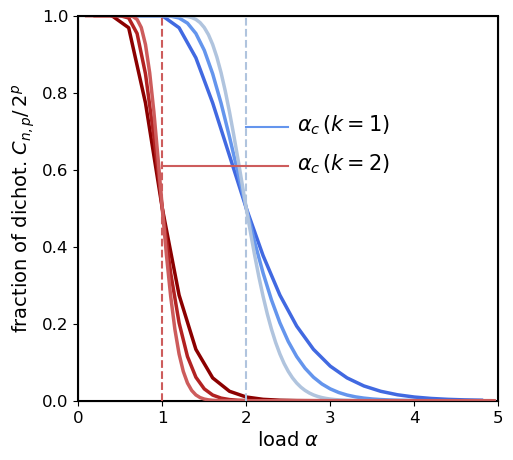

In [13]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.plot(a_1, l_1, color='royalblue', linewidth=2.5, label='N=5')
ax.plot(a_2, l_2, color='cornflowerblue', linewidth=2.5, label='N=10')
ax.plot(a_3, l_3, color='lightsteelblue', linewidth=2.5, label='N=20')
ax.plot(a_1_k2, l_1_k2, color='darkred', linewidth=2.5, label='N=5')
ax.plot(a_2_k2, l_2_k2, color='firebrick', linewidth=2.5, label='N=10')
ax.plot(a_3_k2, l_3_k2, color='indianred', linewidth=2.5, label='N=20')
ax.axvline(2, linestyle='--', color='lightsteelblue')
ax.axvline(alpha_c(0.), linestyle='--', color='indianred')
ax.axhline(0.71, xmin=0.4, xmax=0.5,  linestyle='-', color='cornflowerblue')
ax.axhline(0.61, xmin=0.2, xmax=0.5, linestyle='-', color='indianred')
ax.set_xlabel(r'load $\alpha$')
ax.set_ylabel(r'fraction of dichot. $\mathit{C_{n,p}/\,2^p}$')
ax.set_xlim([0,5])
ax.set_ylim([0,1])
ax.annotate(r'$\alpha_c\,(k=1)$', (0.52, 0.7), textcoords='axes fraction', size=15)
ax.annotate(r'$\alpha_c\,(k=2)$', (0.52, 0.6), textcoords='axes fraction', size=15)
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1.5')  
plt.gcf().subplots_adjust(left=0.2)

## Vapnik – Chervonenkis entropy

The Vapnik – Chervonenkis entropy $\mathcal{H}$ is measure of the size of the loss class, projected on a specific set $Z_p$ and it sets a rigorous bound on the generalization error of the model. The entropy can be computed as:

$$
\mathcal{H}_{\mathcal{L}} (Z_p) = log \mathcal{N}_\mathcal{G} (X_p)
$$
where $\mathcal{N}_\mathcal{G} (X_p)$ is the number of dichotomies of the set $X_p$ realizable by $\mathcal{G}$.

In [14]:
N_1, N_2, N_3, N_4 = 5, 10, 25, 50
l_1_e, l_2_e, l_3_e, l_4_e = [], [], [], []
a_1_e, a_2_e, a_3_e, a_4_e = [], [], [], []
factor = 11
rho = 0.3

l_1_e = [C_matrix(N_1,P,rho) for P in range(1,int(factor*N_1))]
a_1_e = [P/N_1 for P in range(1,int(factor*N_1))]

l_2_e = [C_matrix(N_2,P,rho) for P in range(1,int(factor*N_2))]
a_2_e = [P/N_2  for P in range(1,int(factor*N_2))]

l_3_e = [C_matrix(N_3,P,rho) for P in range(1,int(factor*N_3))]
a_3_e = [P/N_3  for P in range(1,int(factor*N_3))]

l_4_e = [C_matrix(N_4,P,rho) for P in range(1,int(factor*N_4))]
a_4_e = [P/N_4  for P in range(1,int(factor*N_4))]

C:\Users\giovanni\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
C:\Users\giovanni\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


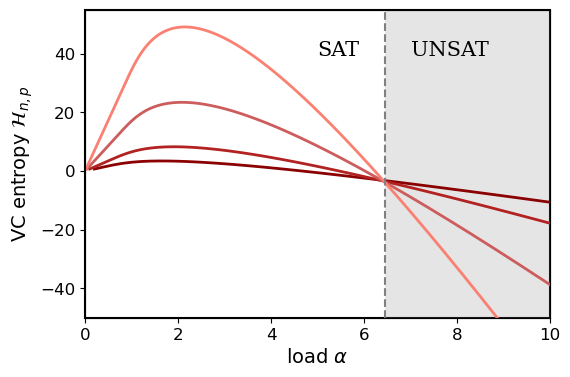

In [15]:
# Find intersection point
line0 = LineString(np.column_stack((a_3_e, np.log(l_3_e))))
line1 = LineString(np.column_stack((a_4_e, np.log(l_4_e))))

intersection = line0.intersection(line1)
x_inter, y_inter = intersection.xy

# Plot
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(a_1_e, np.log(l_1_e), color='darkred', linewidth=2, label='N=5')
ax.plot(a_2_e, np.log(l_2_e), color='firebrick', linewidth=2, label='N=10')
ax.plot(a_3_e, np.log(l_3_e), color='indianred', linewidth=2, label='N=25')
ax.plot(a_4_e, np.log(l_4_e), color='salmon', linewidth=2, label='N=50')
ax.axvline(x_inter[0], linestyle='--', color='grey')
rectangle = mpl.patches.Rectangle((x_inter[0], 0), 13, 0, edgecolor='grey',
facecolor="green", alpha=0.2, linewidth=1037)
ax.add_patch(rectangle)
ax.annotate('SAT',   (0.50, 0.85), textcoords='axes fraction', size=15, fontname='Serif')
ax.annotate('UNSAT', (0.70, 0.85), textcoords='axes fraction', size=15, fontname='Serif')
ax.set_xlabel(r'load $\alpha$')
ax.set_ylabel(r'VC entropy $\mathit{\mathcal{H}_{n,p}}$')
ax.set_xlim([0,10])
ax.set_ylim([-50,55])
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1.5')  

## Satisfiability transition point - $\alpha_*$

The problem with structured data highlights a novel phase transition (SAT - UNSAT transition). Our theory allows to create a trascendental equation for the transition point (in the thermodynamic limit):

$$
(\alpha_* + 1) \log (\alpha_* + 1) - \alpha_* \log (\alpha_*) + (\alpha_* + 1) \log(\psi_2) = 0
$$

In [16]:
# Load transition point in the thermodynamic limit
r, values = np.loadtxt('../results/table_alpha.dat', dtype=float, unpack=True)

# Use interpolation as reference value
alpha_interp = interp1d(r, values, assume_sorted=True)

rhos_entropy = np.arange(-0.9, 0.9, 0.1, dtype=float)
astar_entropy_small, astar_entropy_large = [], []
alpha_min_lim, alpha_max_lim = 0., 0.

for rr in rhos_entropy: 
    
    # Bounds for astar
    alpha_min_lim = alpha_interp(rr) - 1.
    alpha_max_lim = alpha_interp(rr)
    
    if alpha_min_lim < 1.:
        alpha_min_lim = 1.
    
    curve0 = compute_entropy(4, rr, alpha_min_lim, alpha_max_lim)
    curve1 = compute_entropy(5, rr, alpha_min_lim, alpha_max_lim)
    
    curve2 = compute_entropy(45, rr, alpha_min_lim, alpha_max_lim)
    curve3 = compute_entropy(50, rr, alpha_min_lim, alpha_max_lim)
    
    x_int_0, y_int_0 = compute_intersection(curve0, curve1)
    x_int_1, y_int_1 = compute_intersection(curve2, curve3)
    
    astar_entropy_small.append(x_int_0)
    astar_entropy_large.append(x_int_1)


    print(f"End computation for rho = {rr:.1f}")

End computation for rho = -0.9
End computation for rho = -0.8
End computation for rho = -0.7
End computation for rho = -0.6
End computation for rho = -0.5
End computation for rho = -0.4
End computation for rho = -0.3
End computation for rho = -0.2
End computation for rho = -0.1
End computation for rho = -0.0
End computation for rho = 0.1
End computation for rho = 0.2
End computation for rho = 0.3
End computation for rho = 0.4
End computation for rho = 0.5
End computation for rho = 0.6
End computation for rho = 0.7
End computation for rho = 0.8


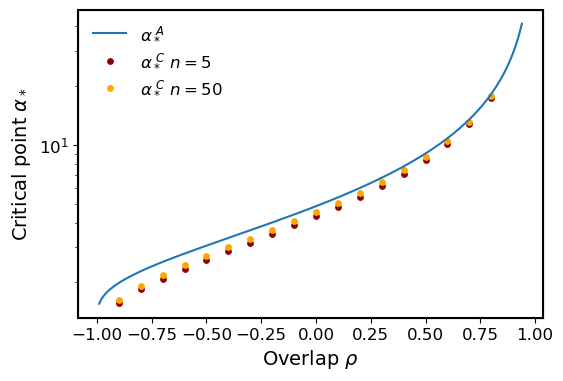

In [17]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(r[:-5], values[:-5], label=r'$\alpha_*^{\,\,A}$')
ax.scatter(rhos_entropy, astar_entropy_small, s=15, label=r'$\alpha_*^{\,\,C}$ $n=5$', marker='o', c='darkred')
ax.scatter(rhos_entropy, astar_entropy_large, s=15, label=r'$\alpha_*^{\,\,C}$ $n=50$', marker='o', c='orange')
ax.set_xlabel(r'Overlap $\rho$')
ax.set_ylabel(r'Critical point $\alpha_*$')
ax.set_yscale('log')
ax.legend(loc='best', framealpha=0.)
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('1.5')